<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_Sampleset_12pts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb']

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [4]:
from utils.hourglass import *
from utils.dataloader import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
# helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)

In [ ]:
# helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)

In [ ]:
# train_dataloder = DataLoader(helen_trainset, batch_size=25)
# test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [ ]:
# helen_sampleset = Helen_set(dataset_type="sample")
# sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

In [ ]:
# critical = torch.nn.MSELoss()

# nIters = 200
# HGNet = HGNet().to(device)
# optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
# loss_hist = torch.zeros(nIters)
# loss_epoch = torch.zeros(10)

# for iter in range(nIters):
#   for i, (x,_,y) in enumerate(sample_dataloder):
#     x = Variable(x,requires_grad=True).float().to(device)
#     y = Variable(y).float().to(device)
#     y_pred = HGNet.forward(x)
#     loss = critical(y_pred, y)
#     loss_epoch[i] = loss.item()

#     if i == 9:
#       loss_avg = torch.sum(loss_epoch)/10
#       loss_hist[iter] = loss_avg
#       if (iter+1)%10 == 0 or iter == 0:
#         print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
# plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

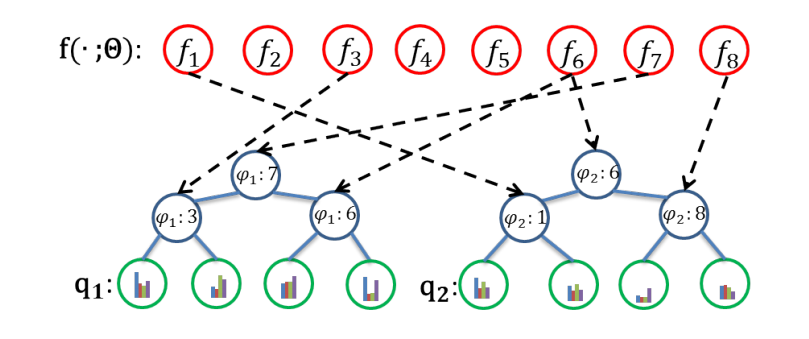

In [6]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [7]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [8]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [9]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
    
  return out

In [10]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [11]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [12]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [13]:
def loss_ce(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -criterion_KL(l,pred)

def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

def loss_alogb(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -torch.sum(l*torch.log(pred))/B

In [14]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

## 4.2 Sample Set

In [15]:
helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
sample_dataloder = DataLoader(helen_sampleset, batch_size=20) 
helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.3 Network

In [16]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [17]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.4 Training

In [18]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 200
learning_rate = 0.01

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [ ]:
# Using L2 Loss

for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12*256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q).reshape(B,12,256,256)
      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)

      loss_epoch += loss.item()
      if (iter+1)%20 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12*256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      leaf_q_new += torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)

    leaf_q = leaf_q_new/10  # average among each bach
    leaf_q = torch.abs(leaf_q.reshape(num_leaf_nodes,12,-1)) #(B,12,256*256)
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    for nleaf in range(num_leaf_nodes):
      for npoints in range(12):
        leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))





###########################################################
Round 1, Using GPU


NameError: ignored

### Training using Log likelihood

############################################################################
Round [1/10], Using GPU
     CNN training, Iter [1/30], loss_CE: 133.0764
     CNN training, Iter [5/30], loss_CE: 133.0764
     CNN training, Iter [10/30], loss_CE: 133.0764
     CNN training, Iter [15/30], loss_CE: 133.0764
     CNN training, Iter [20/30], loss_CE: 133.0764
     CNN training, Iter [25/30], loss_CE: 133.0764
     CNN training, Iter [30/30], loss_CE: 133.0764
     -----> CNN training time: ## 3.20 mins ## 


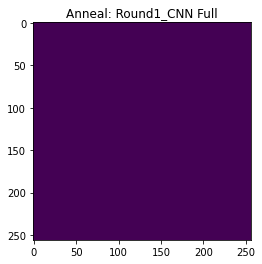

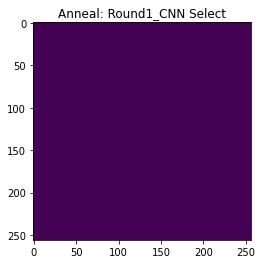

     RF training, Batch 1, rf_iter [1/60], loss_CE: 87.7899
     RF training, Batch 1, rf_iter [10/60], loss_CE: 84.1928
     RF training, Batch 1, rf_iter [20/60], loss_CE: 83.6687
     RF training, Batch 1, rf_iter [30/60], loss_CE: 83.5367
     RF training, Batch 1, rf_iter [40/60], loss_CE: 83.4843
     RF training, Batch 1, rf_iter [50/60], loss_CE: 83.4578
     RF training, Batch 1, rf_iter [60/60], loss_CE: 83.4422
     RF training, Batch 4, rf_iter [1/60], loss_CE: 89.5045
     RF training, Batch 4, rf_iter [10/60], loss_CE: 86.0101
     RF training, Batch 4, rf_iter [20/60], loss_CE: 85.4387
     RF training, Batch 4, rf_iter [30/60], loss_CE: 85.2934
     RF training, Batch 4, rf_iter [40/60], loss_CE: 85.2372
     RF training, Batch 4, rf_iter [50/60], loss_CE: 85.2099
     RF training, Batch 4, rf_iter [60/60], loss_CE: 85.1945
     RF training, Batch 8, rf_iter [1/60], loss_CE: 88.7436
     RF training, Batch 8, rf_iter [10/60], loss_CE: 84.9161
     RF training, Batch 8, 

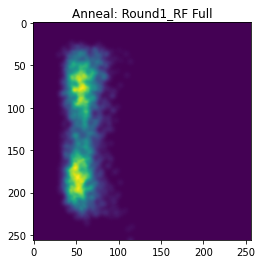

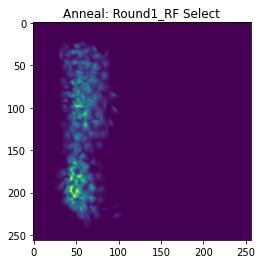

     RF training, coordinate loss: 282.85, after selcetion: 279.05
     -----> RF training time: ## 8.78 mins ## 
     -----> Training time for this round: ## 11.97 mins ## 
############################################################################
Round [2/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 97.0128
     CNN training, Iter [5/200], loss_CE: 90.3189
     CNN training, Iter [10/200], loss_CE: 87.8049
     CNN training, Iter [15/200], loss_CE: 87.0111
     CNN training, Iter [20/200], loss_CE: 86.7729
     CNN training, Iter [25/200], loss_CE: 86.6639
     CNN training, Iter [30/200], loss_CE: 86.5820
     CNN training, Iter [35/200], loss_CE: 86.5728
     CNN training, Iter [40/200], loss_CE: 86.5210
     CNN training, Iter [45/200], loss_CE: 86.4609
     CNN training, Iter [50/200], loss_CE: 86.4623
     CNN training, Iter [55/200], loss_CE: 86.4538
     CNN training, Iter [60/200], loss_CE: 86.4003
     CNN training, Iter [65/200], loss_CE: 86.3329
     CNN trai

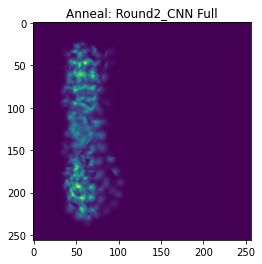

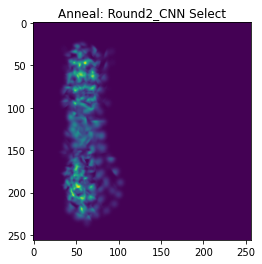

     RF training, Batch 1, rf_iter [1/60], loss_CE: 67.1586
     RF training, Batch 1, rf_iter [10/60], loss_CE: 65.2865
     RF training, Batch 1, rf_iter [20/60], loss_CE: 65.1516
     RF training, Batch 1, rf_iter [30/60], loss_CE: 65.1151
     RF training, Batch 1, rf_iter [40/60], loss_CE: 65.1016
     RF training, Batch 1, rf_iter [50/60], loss_CE: 65.0951
     RF training, Batch 1, rf_iter [60/60], loss_CE: 65.0913
     RF training, Batch 4, rf_iter [1/60], loss_CE: 66.8525
     RF training, Batch 4, rf_iter [10/60], loss_CE: 65.2652
     RF training, Batch 4, rf_iter [20/60], loss_CE: 65.1493
     RF training, Batch 4, rf_iter [30/60], loss_CE: 65.1156
     RF training, Batch 4, rf_iter [40/60], loss_CE: 65.1016
     RF training, Batch 4, rf_iter [50/60], loss_CE: 65.0943
     RF training, Batch 4, rf_iter [60/60], loss_CE: 65.0898
     RF training, Batch 8, rf_iter [1/60], loss_CE: 66.6553
     RF training, Batch 8, rf_iter [10/60], loss_CE: 64.7498
     RF training, Batch 8, 

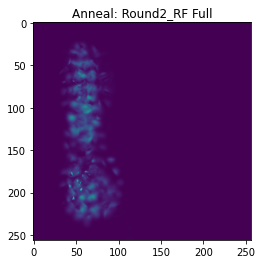

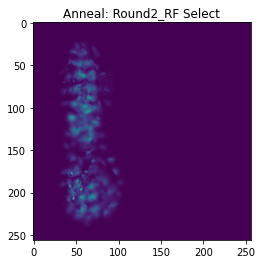

     RF training, coordinate loss: 28.56, after selcetion: 51.89
     -----> RF training time: ## 8.72 mins ## 
     -----> Training time for this round: ## 29.89 mins ## 
############################################################################
Round [3/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 81.8166
     CNN training, Iter [5/200], loss_CE: 81.1118
     CNN training, Iter [10/200], loss_CE: 80.8525
     CNN training, Iter [15/200], loss_CE: 80.7802
     CNN training, Iter [20/200], loss_CE: 80.7810
     CNN training, Iter [25/200], loss_CE: 80.7680
     CNN training, Iter [30/200], loss_CE: 80.7702
     CNN training, Iter [35/200], loss_CE: 80.7569
     CNN training, Iter [40/200], loss_CE: 80.7659
     CNN training, Iter [45/200], loss_CE: 80.7654
     CNN training, Iter [50/200], loss_CE: 80.7526
     CNN training, Iter [55/200], loss_CE: 80.7593
     CNN training, Iter [60/200], loss_CE: 80.7562
     CNN training, Iter [65/200], loss_CE: 80.7587
     CNN traini

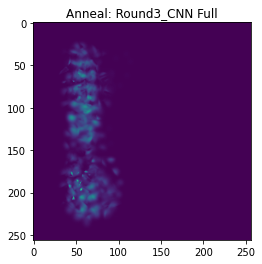

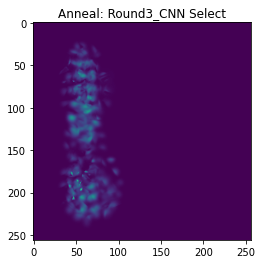

     RF training, Batch 1, rf_iter [1/60], loss_CE: 65.2893
     RF training, Batch 1, rf_iter [10/60], loss_CE: 64.4961
     RF training, Batch 1, rf_iter [20/60], loss_CE: 64.4407
     RF training, Batch 1, rf_iter [30/60], loss_CE: 64.4240
     RF training, Batch 1, rf_iter [40/60], loss_CE: 64.4170
     RF training, Batch 1, rf_iter [50/60], loss_CE: 64.4134
     RF training, Batch 1, rf_iter [60/60], loss_CE: 64.4113
     RF training, Batch 4, rf_iter [1/60], loss_CE: 65.1438
     RF training, Batch 4, rf_iter [10/60], loss_CE: 64.3292
     RF training, Batch 4, rf_iter [20/60], loss_CE: 64.2742
     RF training, Batch 4, rf_iter [30/60], loss_CE: 64.2598
     RF training, Batch 4, rf_iter [40/60], loss_CE: 64.2534
     RF training, Batch 4, rf_iter [50/60], loss_CE: 64.2499
     RF training, Batch 4, rf_iter [60/60], loss_CE: 64.2476
     RF training, Batch 8, rf_iter [1/60], loss_CE: 64.4043
     RF training, Batch 8, rf_iter [10/60], loss_CE: 63.6012
     RF training, Batch 8, 

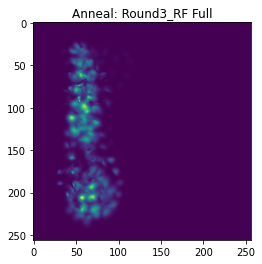

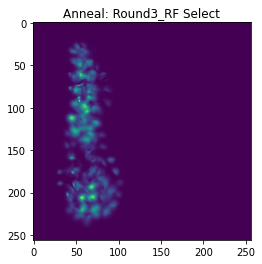

     RF training, coordinate loss: 20.95, after selcetion: 29.09
     -----> RF training time: ## 8.69 mins ## 
     -----> Training time for this round: ## 29.73 mins ## 
############################################################################
Round [4/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.9312
     CNN training, Iter [5/200], loss_CE: 79.7773
     CNN training, Iter [10/200], loss_CE: 79.7392
     CNN training, Iter [15/200], loss_CE: 79.7289
     CNN training, Iter [20/200], loss_CE: 79.7349
     CNN training, Iter [25/200], loss_CE: 79.7242
     CNN training, Iter [30/200], loss_CE: 79.7223
     CNN training, Iter [35/200], loss_CE: 79.7244
     CNN training, Iter [40/200], loss_CE: 79.7261
     CNN training, Iter [45/200], loss_CE: 79.7265
     CNN training, Iter [50/200], loss_CE: 79.7265
     CNN training, Iter [55/200], loss_CE: 79.7314
     CNN training, Iter [60/200], loss_CE: 79.7183
     CNN training, Iter [65/200], loss_CE: 79.7172
     CNN traini

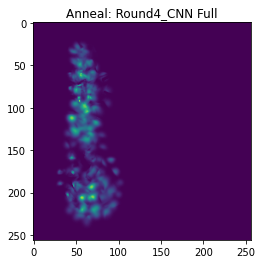

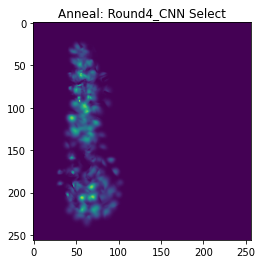

     RF training, Batch 1, rf_iter [1/60], loss_CE: 64.4422
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.6693
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.6227
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.6099
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.6041
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.6009
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.5991
     RF training, Batch 4, rf_iter [1/60], loss_CE: 64.6086
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.8921
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.8444
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.8327
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.8280
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.8257
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.8244
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.7214
     RF training, Batch 8, rf_iter [10/60], loss_CE: 63.0911
     RF training, Batch 8, 

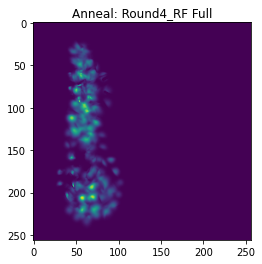

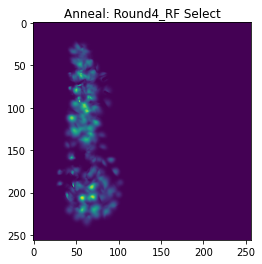

     RF training, coordinate loss: 24.15, after selcetion: 27.12
     -----> RF training time: ## 8.98 mins ## 
     -----> Training time for this round: ## 30.38 mins ## 
############################################################################
Round [5/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.3884
     CNN training, Iter [5/200], loss_CE: 79.3696
     CNN training, Iter [10/200], loss_CE: 79.3616
     CNN training, Iter [15/200], loss_CE: 79.3488
     CNN training, Iter [20/200], loss_CE: 79.3402
     CNN training, Iter [25/200], loss_CE: 79.3379
     CNN training, Iter [30/200], loss_CE: 79.3446
     CNN training, Iter [35/200], loss_CE: 79.3350
     CNN training, Iter [40/200], loss_CE: 79.3329
     CNN training, Iter [45/200], loss_CE: 79.3255
     CNN training, Iter [50/200], loss_CE: 79.3299
     CNN training, Iter [55/200], loss_CE: 79.3299
     CNN training, Iter [60/200], loss_CE: 79.3282
     CNN training, Iter [65/200], loss_CE: 79.3212
     CNN traini

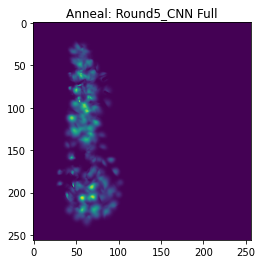

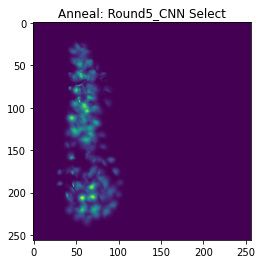

     RF training, Batch 1, rf_iter [1/60], loss_CE: 64.0434
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.4163
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.3930
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.3873
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.3850
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.3838
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.3831
     RF training, Batch 4, rf_iter [1/60], loss_CE: 64.2866
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.6405
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.6008
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.5858
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.5773
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.5724
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.5696
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.4583
     RF training, Batch 8, rf_iter [10/60], loss_CE: 62.9285
     RF training, Batch 8, 

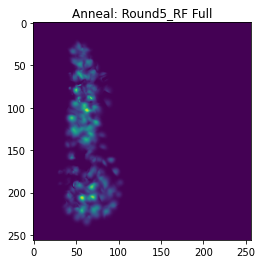

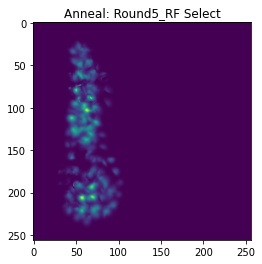

     RF training, coordinate loss: 20.66, after selcetion: 24.68
     -----> RF training time: ## 8.85 mins ## 
     -----> Training time for this round: ## 29.95 mins ## 
############################################################################
Round [6/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.2072
     CNN training, Iter [5/200], loss_CE: 79.1719
     CNN training, Iter [10/200], loss_CE: 79.1740
     CNN training, Iter [15/200], loss_CE: 79.1707
     CNN training, Iter [20/200], loss_CE: 79.1719
     CNN training, Iter [25/200], loss_CE: 79.1684
     CNN training, Iter [30/200], loss_CE: 79.1653
     CNN training, Iter [35/200], loss_CE: 79.1626
     CNN training, Iter [40/200], loss_CE: 79.1692
     CNN training, Iter [45/200], loss_CE: 79.1629
     CNN training, Iter [50/200], loss_CE: 79.1628
     CNN training, Iter [55/200], loss_CE: 79.1620
     CNN training, Iter [60/200], loss_CE: 79.1638
     CNN training, Iter [65/200], loss_CE: 79.1687
     CNN traini

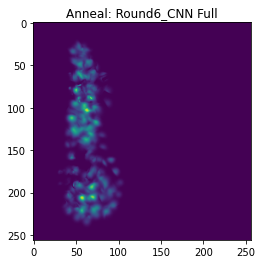

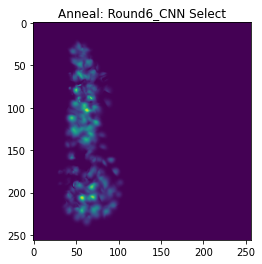

     RF training, Batch 1, rf_iter [1/60], loss_CE: 63.9591
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.2885
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.2663
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.2607
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.2583
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.2571
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.2564
     RF training, Batch 4, rf_iter [1/60], loss_CE: 63.9364
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.3985
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.3779
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.3718
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.3688
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.3671
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.3659
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.3217
     RF training, Batch 8, rf_iter [10/60], loss_CE: 62.8101
     RF training, Batch 8, 

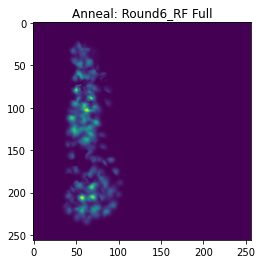

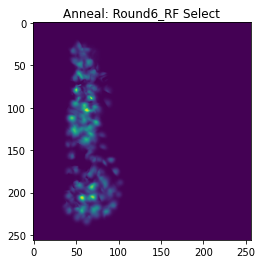

     RF training, coordinate loss: 19.52, after selcetion: 20.61
     -----> RF training time: ## 8.69 mins ## 
     -----> Training time for this round: ## 29.76 mins ## 
############################################################################
Round [7/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.0924
     CNN training, Iter [5/200], loss_CE: 79.0942
     CNN training, Iter [10/200], loss_CE: 79.0943
     CNN training, Iter [15/200], loss_CE: 79.0907
     CNN training, Iter [20/200], loss_CE: 79.0856
     CNN training, Iter [25/200], loss_CE: 79.0877
     CNN training, Iter [30/200], loss_CE: 79.0878
     CNN training, Iter [35/200], loss_CE: 79.0866
     CNN training, Iter [40/200], loss_CE: 79.0859
     CNN training, Iter [45/200], loss_CE: 79.0880
     CNN training, Iter [50/200], loss_CE: 79.0900
     CNN training, Iter [55/200], loss_CE: 79.0828
     CNN training, Iter [60/200], loss_CE: 79.0859
     CNN training, Iter [65/200], loss_CE: 79.0818
     CNN traini

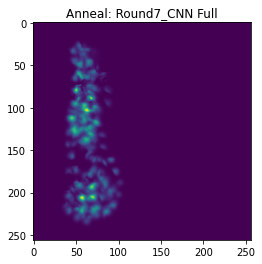

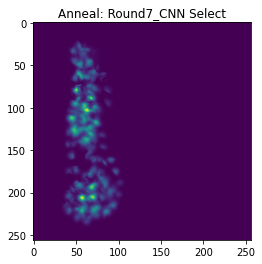

     RF training, Batch 1, rf_iter [1/60], loss_CE: 63.9485
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.3150
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.2930
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.2873
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.2848
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.2835
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.2827
     RF training, Batch 4, rf_iter [1/60], loss_CE: 63.9298
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.3911
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.3652
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.3547
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.3484
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.3444
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.3420
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.2054
     RF training, Batch 8, rf_iter [10/60], loss_CE: 62.7198
     RF training, Batch 8, 

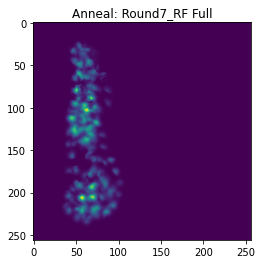

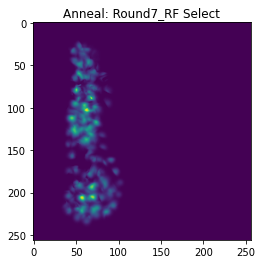

     RF training, coordinate loss: 20.35, after selcetion: 21.06
     -----> RF training time: ## 8.66 mins ## 
     -----> Training time for this round: ## 29.49 mins ## 
############################################################################
Round [8/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.0544
     CNN training, Iter [5/200], loss_CE: 79.0632
     CNN training, Iter [10/200], loss_CE: 79.0564
     CNN training, Iter [15/200], loss_CE: 79.0622
     CNN training, Iter [20/200], loss_CE: 79.0568
     CNN training, Iter [25/200], loss_CE: 79.0638
     CNN training, Iter [30/200], loss_CE: 79.0650
     CNN training, Iter [35/200], loss_CE: 79.0614
     CNN training, Iter [40/200], loss_CE: 79.0573
     CNN training, Iter [45/200], loss_CE: 79.0587
     CNN training, Iter [50/200], loss_CE: 79.0591
     CNN training, Iter [55/200], loss_CE: 79.0577
     CNN training, Iter [60/200], loss_CE: 79.0608
     CNN training, Iter [65/200], loss_CE: 79.0566
     CNN traini

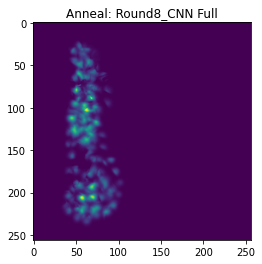

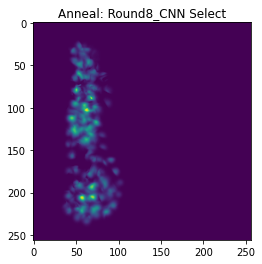

     RF training, Batch 1, rf_iter [1/60], loss_CE: 64.1490
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.5189
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.4874
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.4789
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.4754
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.4737
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.4728
     RF training, Batch 4, rf_iter [1/60], loss_CE: 63.8666
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.2868
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.2653
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.2603
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.2581
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.2569
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.2561
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.1544
     RF training, Batch 8, rf_iter [10/60], loss_CE: 62.6758
     RF training, Batch 8, 

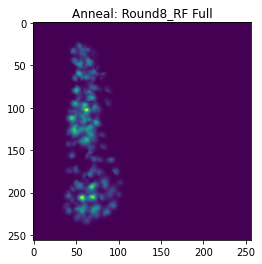

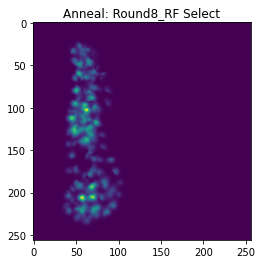

     RF training, coordinate loss: 19.90, after selcetion: 22.71
     -----> RF training time: ## 8.64 mins ## 
     -----> Training time for this round: ## 29.41 mins ## 
############################################################################
Round [9/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.0469
     CNN training, Iter [5/200], loss_CE: 79.0496
     CNN training, Iter [10/200], loss_CE: 79.0521
     CNN training, Iter [15/200], loss_CE: 79.0533
     CNN training, Iter [20/200], loss_CE: 79.0503
     CNN training, Iter [25/200], loss_CE: 79.0465
     CNN training, Iter [30/200], loss_CE: 79.0520
     CNN training, Iter [35/200], loss_CE: 79.0451
     CNN training, Iter [40/200], loss_CE: 79.0502
     CNN training, Iter [45/200], loss_CE: 79.0464
     CNN training, Iter [50/200], loss_CE: 79.0483
     CNN training, Iter [55/200], loss_CE: 79.0447
     CNN training, Iter [60/200], loss_CE: 79.0481
     CNN training, Iter [65/200], loss_CE: 79.0495
     CNN traini

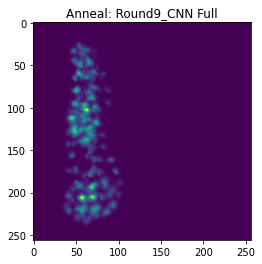

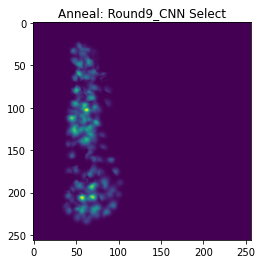

     RF training, Batch 1, rf_iter [1/60], loss_CE: 64.1527
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.5414
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.5181
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.5129
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.5108
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.5097
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.5090
     RF training, Batch 4, rf_iter [1/60], loss_CE: 63.7639
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.2052
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.1843
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.1790
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.1765
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.1750
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.1740
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.1987
     RF training, Batch 8, rf_iter [10/60], loss_CE: 62.7051
     RF training, Batch 8, 

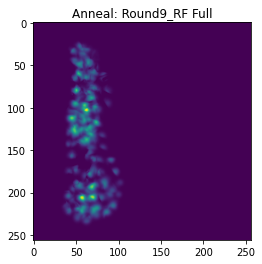

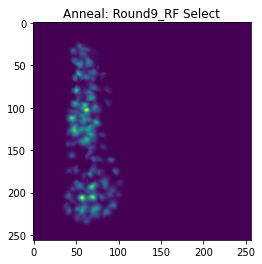

     RF training, coordinate loss: 19.80, after selcetion: 20.45
     -----> RF training time: ## 8.62 mins ## 
     -----> Training time for this round: ## 29.34 mins ## 
############################################################################
Round [10/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 79.0192
     CNN training, Iter [5/200], loss_CE: 79.0300
     CNN training, Iter [10/200], loss_CE: 79.0206
     CNN training, Iter [15/200], loss_CE: 79.0148
     CNN training, Iter [20/200], loss_CE: 79.0169
     CNN training, Iter [25/200], loss_CE: 79.0167
     CNN training, Iter [30/200], loss_CE: 79.0160
     CNN training, Iter [35/200], loss_CE: 79.0144
     CNN training, Iter [40/200], loss_CE: 79.0100
     CNN training, Iter [45/200], loss_CE: 79.0070
     CNN training, Iter [50/200], loss_CE: 79.0164
     CNN training, Iter [55/200], loss_CE: 79.0116
     CNN training, Iter [60/200], loss_CE: 79.0112
     CNN training, Iter [65/200], loss_CE: 79.0110
     CNN train

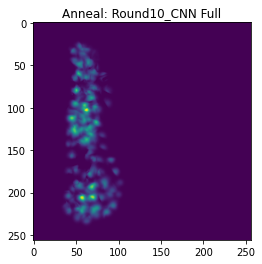

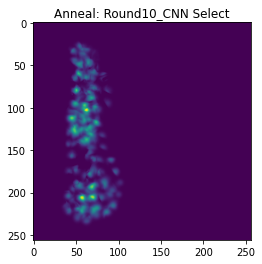

     RF training, Batch 1, rf_iter [1/60], loss_CE: 63.8587
     RF training, Batch 1, rf_iter [10/60], loss_CE: 63.2475
     RF training, Batch 1, rf_iter [20/60], loss_CE: 63.2226
     RF training, Batch 1, rf_iter [30/60], loss_CE: 63.2165
     RF training, Batch 1, rf_iter [40/60], loss_CE: 63.2140
     RF training, Batch 1, rf_iter [50/60], loss_CE: 63.2127
     RF training, Batch 1, rf_iter [60/60], loss_CE: 63.2119
     RF training, Batch 4, rf_iter [1/60], loss_CE: 63.9255
     RF training, Batch 4, rf_iter [10/60], loss_CE: 63.4319
     RF training, Batch 4, rf_iter [20/60], loss_CE: 63.4101
     RF training, Batch 4, rf_iter [30/60], loss_CE: 63.4048
     RF training, Batch 4, rf_iter [40/60], loss_CE: 63.4027
     RF training, Batch 4, rf_iter [50/60], loss_CE: 63.4015
     RF training, Batch 4, rf_iter [60/60], loss_CE: 63.4008
     RF training, Batch 8, rf_iter [1/60], loss_CE: 63.0671
     RF training, Batch 8, rf_iter [10/60], loss_CE: 62.6359
     RF training, Batch 8, 

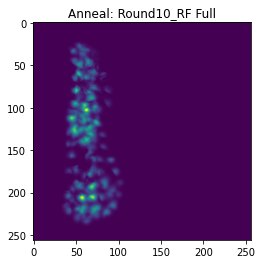

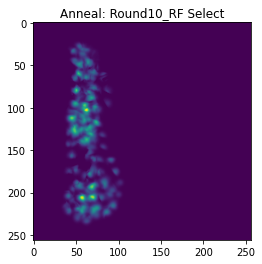

     RF training, coordinate loss: 19.25, after selcetion: 22.47
     -----> RF training time: ## 8.62 mins ## 
     -----> Training time for this round: ## 29.32 mins ## 
-----> Total training time: ## 4.65 hrs ## 


In [19]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      #loss = -criterion_KL(cnn_heatmaps,label_heatmaps)
      loss = -torch.sum(label_heatmaps*torch.log(cnn_heatmaps+1e-8))/B

      loss_epoch += loss.item()
      if (iter+1)%5 == 0 or iter == 0:
        if i == 9:
          loss_epoch = loss_epoch/10
          print('     CNN training, Iter [%d/%d], loss_CE: %.4f' %(iter+1, cnn_Iters, loss_epoch))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  # plot the face after CNN training
  # Does not select
  cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Full")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN_Full.png"))
  plt.show()

  # Selcet
  cnn_prob_test = phi(outputs, mode='test')
  cnn_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Select")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN_Select.png"))
  plt.show()

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0,loss_select = 0,0
    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    new_leaf_q = torch.zeros(leaf_q.shape).to(device)

    for i, (x,coord,y) in enumerate(sample_dataloder):
      next_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)
      cnn_prob_select = phi(outputs, mode='test')
  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          next_leaf_q[:,points_id,:] = update_iter(next_leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%4 == 0 or i == 0) and ((rf_iter+1)%10 == 0 or rf_iter == 0):
          rf_loss_CE = loss_alogb(B, next_leaf_q, cnn_prob, y_expand)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_CE: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE))

      # Calculate loss
      pred_coord0 = find_coord(torch.matmul(cnn_prob,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))/B
      pred_coord_select = find_coord(torch.matmul(cnn_prob_select,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss_select += torch.sum(torch.abs(pred_coord_select-coord[:,36:48,:].reshape(B,-1)))/B

      # update leaf node
      new_leaf_q += next_leaf_q
    leaf_q = new_leaf_q/torch.sum(new_leaf_q, axis=2, keepdims=True)
    


  # plot the face after rf training
  # Does not select
  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Full")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Full.png"))
  plt.show()

  # Select
  cnn_prob_test = phi(outputs, mode='test')
  rf_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Select")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Select.png"))
  plt.show()

  print("     RF training, coordinate loss: %.2f, after selcetion: %.2f" %(loss0/10, loss_select/10))

  # save parameters for this round
  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.5 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian),"_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt")))
leaf_q = torch.load(os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian),"_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [27]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps_select = torch.matmul(phi(outputs,mode='test'),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_heatmaps = torch.matmul(phi(outputs),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coord0 = find_coord(pred_heatmaps)
  pred_coords = find_coord(pred_heatmaps_select) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

RuntimeError: ignored

In [21]:
phi(outputs)[0:5,:]

tensor([[5.4067e-03, 1.3361e-03, 3.0002e-05, 4.0554e-04, 9.0197e-04, 1.6126e-02,
         4.4321e-02, 4.6423e-01, 4.2167e-03, 1.1581e-03, 1.4183e-02, 5.4983e-02,
         3.5097e-01, 9.2472e-03, 3.1688e-02, 7.9247e-04, 2.5970e-05, 2.0980e-03,
         5.7098e-04, 4.7546e-06, 3.9115e-05, 3.9146e-04, 5.7813e-04, 1.0501e-04,
         9.7748e-04, 7.0253e-03, 2.1928e-02, 1.0398e-01, 3.9347e-01, 3.2367e-01,
         9.5522e-02, 4.9617e-02, 1.0375e-05, 6.6597e-06, 1.2604e-08, 4.8993e-06,
         7.0066e-06, 1.0431e-06, 8.1802e-05, 2.2238e-05, 8.9195e-03, 6.3654e-02,
         2.8428e-03, 1.7537e-03, 8.0701e-02, 3.7722e-02, 8.0946e-04, 8.0346e-01],
        [1.1364e-02, 1.3266e-03, 5.8121e-04, 6.9664e-03, 3.2063e-01, 3.2725e-03,
         5.9322e-03, 1.0415e-01, 3.4111e-01, 7.9049e-03, 1.3838e-01, 5.5898e-02,
         8.4781e-04, 1.1500e-03, 4.6995e-04, 1.7129e-05, 2.8650e-02, 2.4087e-01,
         3.5413e-01, 1.1798e-01, 5.2238e-03, 7.5192e-04, 8.5733e-04, 2.5679e-03,
         9.5758e-02, 1.3742

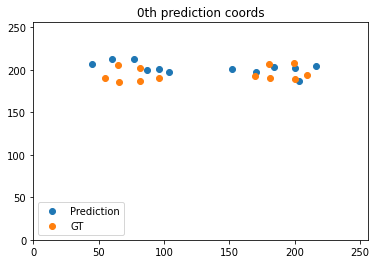

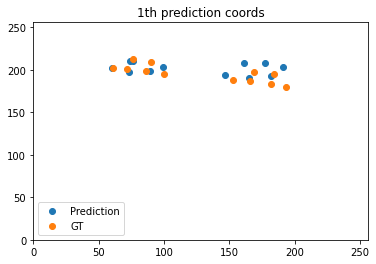

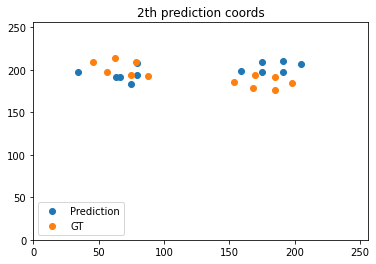

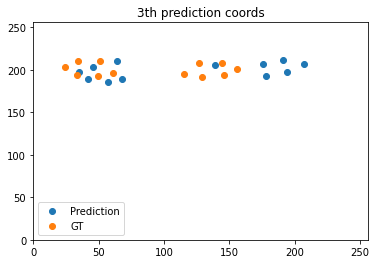

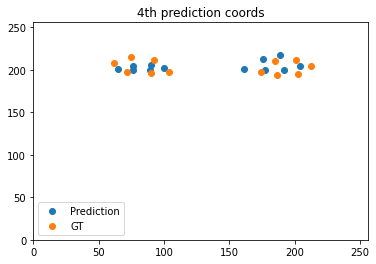

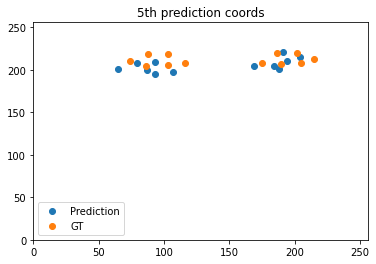

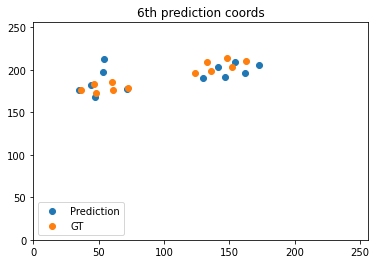

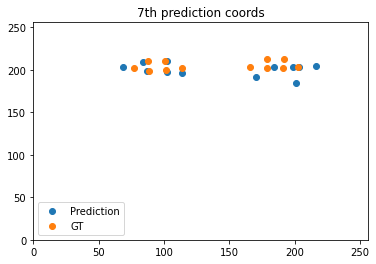

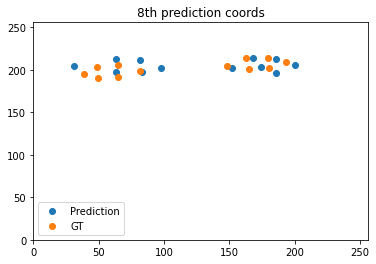

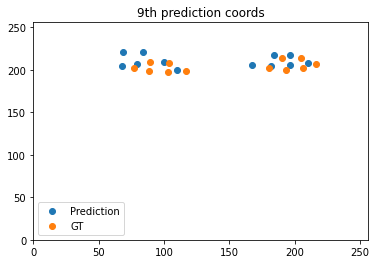

In [22]:
# Coords

for ith in range(10):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  x2 = coord[ith,36:48,0].detach().cpu()
  y2 = coord[ith,36:48,1].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th prediction coords")
  plt.show()

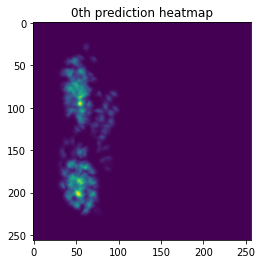

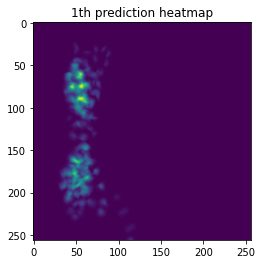

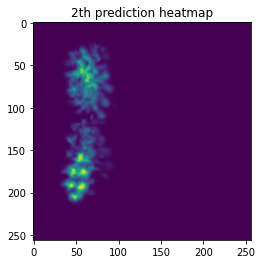

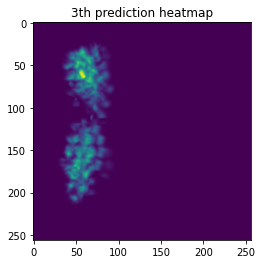

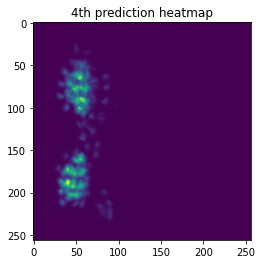

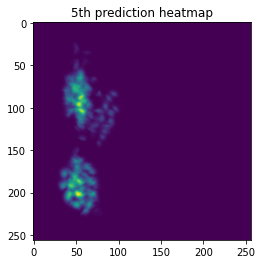

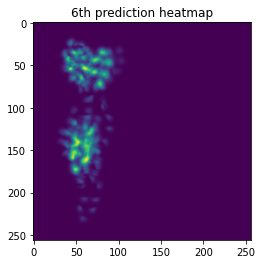

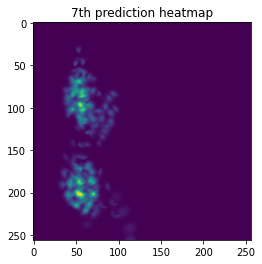

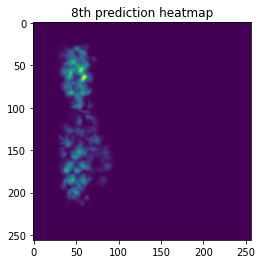

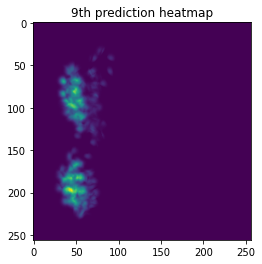

In [23]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
for ith in range(10):
  plt.imshow(plot_heatmaps_all[ith,:,:])
  plt.title(str(ith)+"th prediction heatmap")
  plt.show()

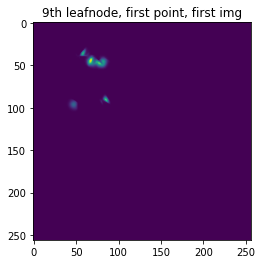

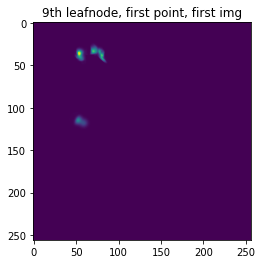

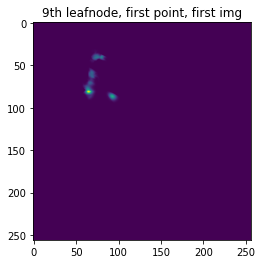

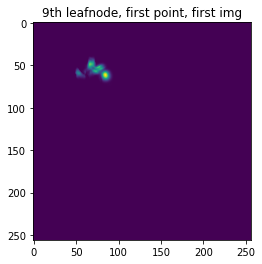

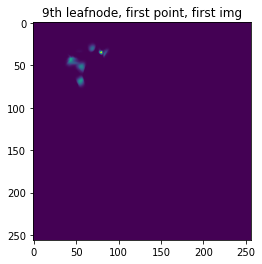

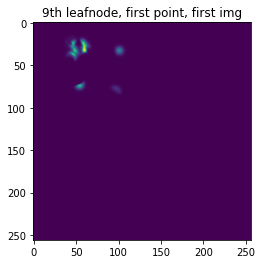

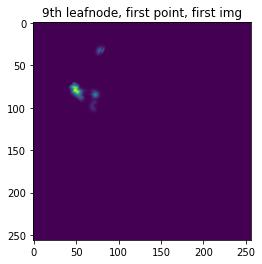

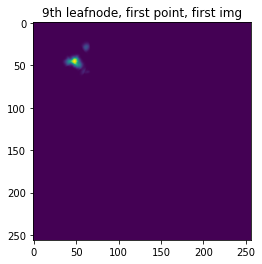

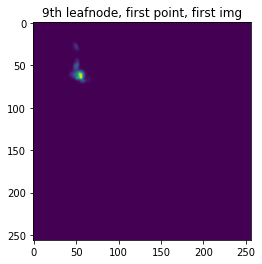

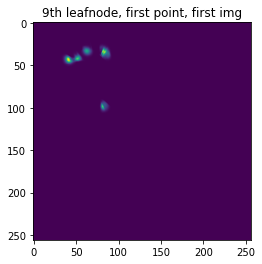

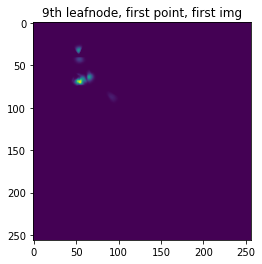

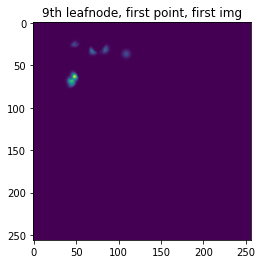

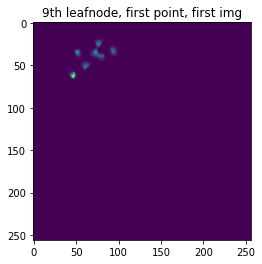

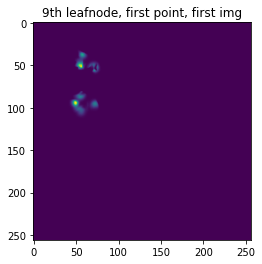

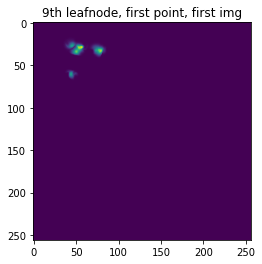

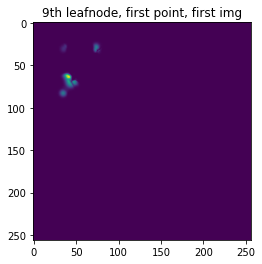

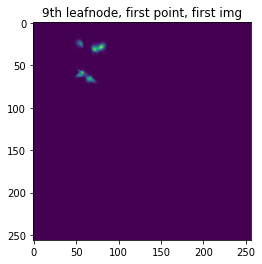

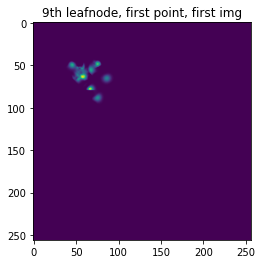

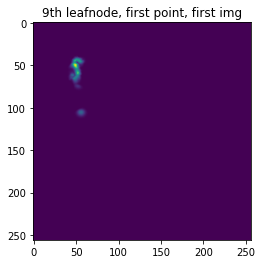

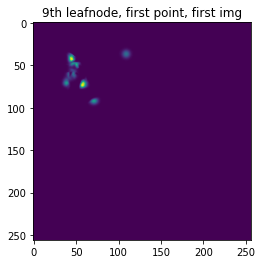

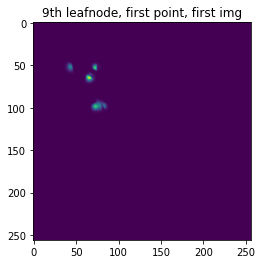

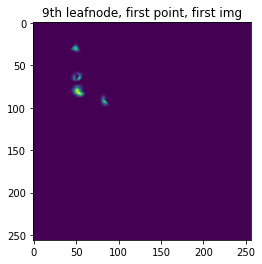

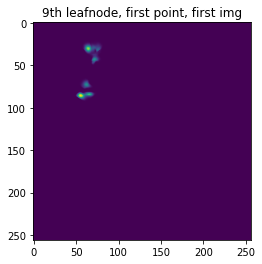

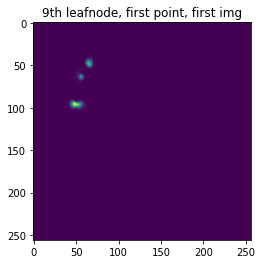

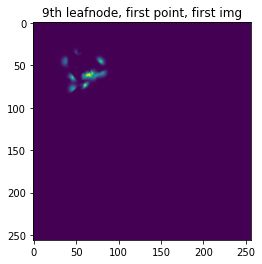

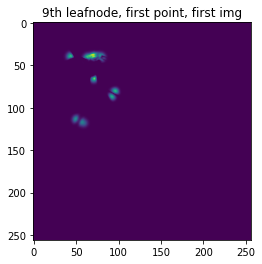

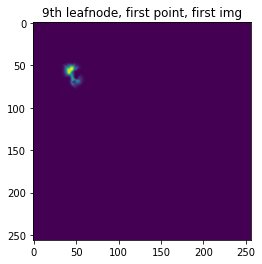

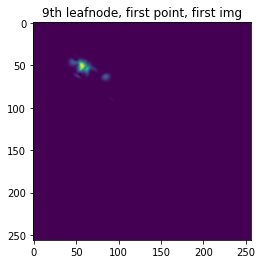

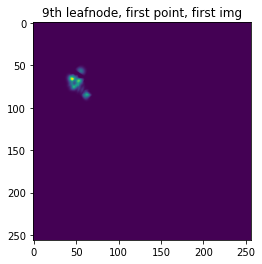

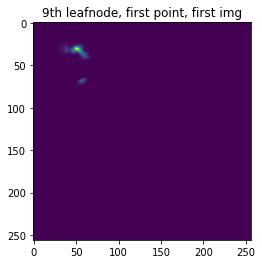

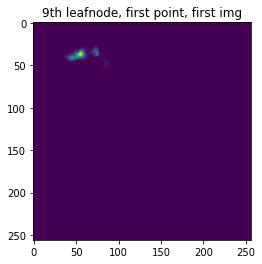

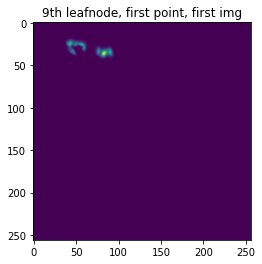

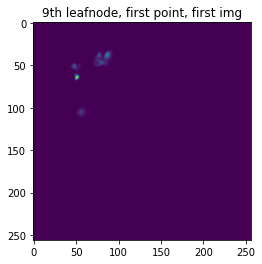

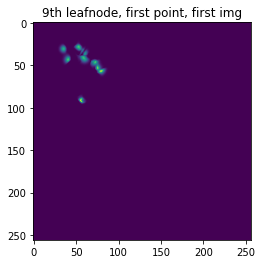

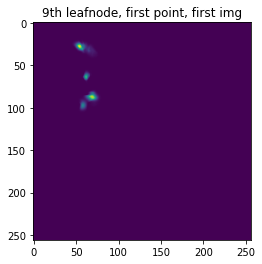

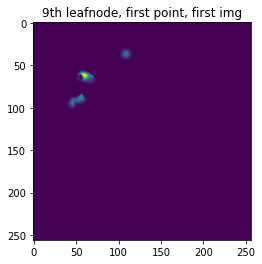

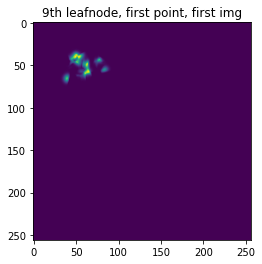

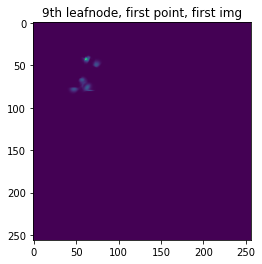

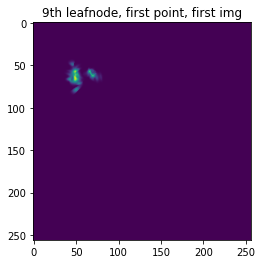

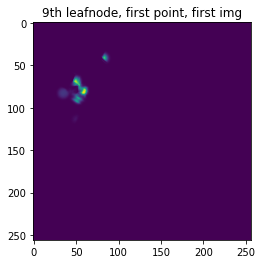

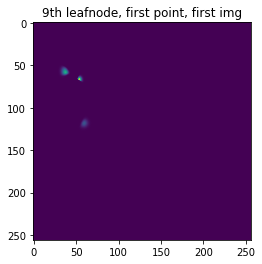

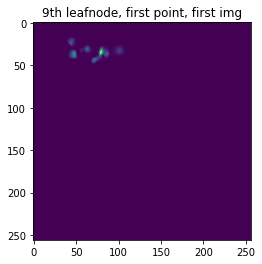

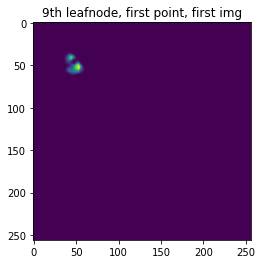

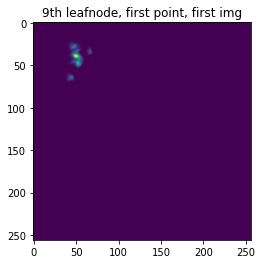

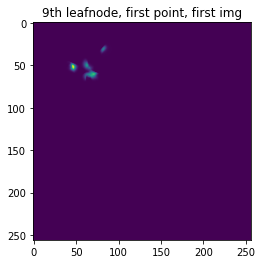

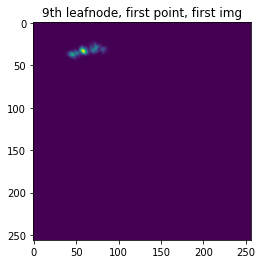

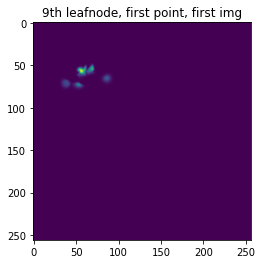

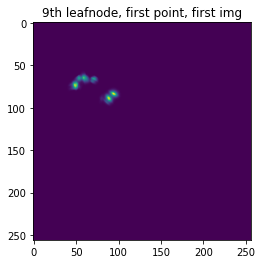

In [24]:
for nleaf in range(48):
  plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[nleaf,0,:,:].detach().cpu())
  plt.title(str(ith)+"th leafnode, first point, first img")
  plt.show()

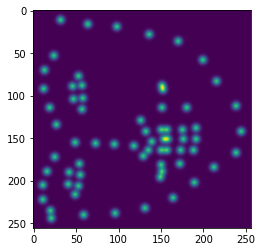

In [25]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

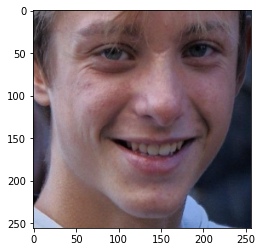

In [26]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())